# Image Classification with CNN using Keras

# Task 1: Import Libraries

In [2]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.0.1
Is using GPU? False


# Task 2: Preprocess Data

In [3]:
# instead of taking all classess we are taking only 3 classess as training will become fast
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y) # converting labels to one-hot encoding vectors and return
    
    return x, y

In [4]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train,y_train)
x_test, y_test = get_three_classes(x_test,y_test)

print(x_train.shape, y_train.shape)  # original training set has 60,000 and test data has 10,000 but we are using 15,000 for training and 3000 for testing
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

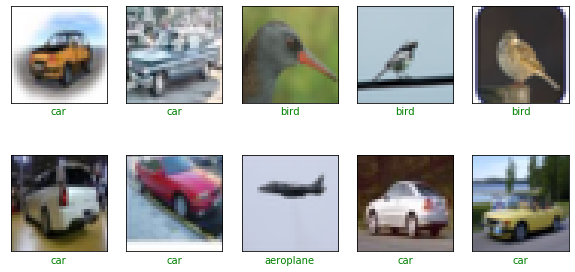

In [5]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]),10,replace=False)  # 1st argument number of examples, 2nd argument how many we want- 10
    x =x[indices]
    y = y[indices]
    p = p[indices]
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col ='green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()
    
show_random_examples(x_train, y_train, y_train) # as we don;t have prediction, sending ground truth

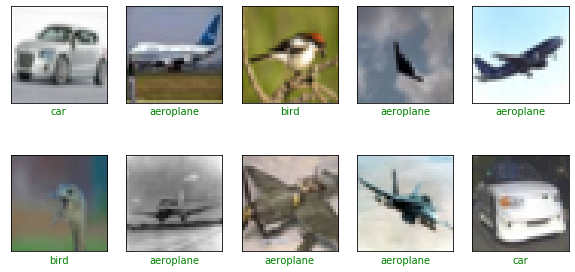

In [6]:
show_random_examples(x_test,y_test,y_test)

# Task 4: Create Model

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model,num_filters):
        model.add(Conv2D(num_filters,3 , activation='relu', padding='same')) # here output will same as i/p dimension
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu')) # here output will change as padding applied, rows and columns will reduce
        model.add(MaxPooling2D(pool_size=2))  # reduces rows and columns by half as pooling we are doing by 2
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32,32,3)))
    
    model = add_conv_block(model,32)  # different filters 32 , 64, 128
    model = add_conv_block(model,64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3,activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam', metrics=['accuracy']
    )
    
    return model

model = create_model()

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

# Task 5: Train the Model

In [ ]:
# Train the model on subset of original data we created

h = model.fit(
    x_train/255. ,y_train,
    validation_data=(x_test/255., y_test),
    epochs =10, batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.ModelCheckpoint(
            'models/model_{val_accuracy:.3f}.h5',
            save_best_only=True,  # saves model only it performs better than previous epoch
            save_weights_only=False,
            monitor='val_accuracy'
        )
    ]
)

Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 155s 10ms/sample - loss: 0.8800 - accuracy: 0.6875 - val_loss: 3.6213 - val_accuracy: 0.3333
Epoch 2/10
13696/15000 [==========================>...] - ETA: 13s - loss: 0.5541 - accuracy: 0.7778

# Task 6: Final Predictions

In [ ]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label="Training")
plt.plot(range(len(accs)), val_accs, label="Validation")
plt.legend()
plt.show()

In [ ]:
model = tf.keras.models.load_model('models/model_0.880.h5')

In [ ]:
preds =model.predict(x_test/255.)

In [ ]:
show_random_examples(x_test,y_test,preds)